In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# PRNU Extraction

In [ ]:
"""
The MIT License (MIT)

Copyright (c) 2018 

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""

'\nThe MIT License (MIT)\n\nCopyright (c) 2018 \n\nPermission is hereby granted, free of charge, to any person obtaining a copy\nof this software and associated documentation files (the "Software"), to deal\nin the Software without restriction, including without limitation the rights\nto use, copy, modify, merge, publish, distribute, sublicense, and/or sell\ncopies of the Software, and to permit persons to whom the Software is\nfurnished to do so, subject to the following conditions:\n\nThe above copyright notice and this permission notice shall be included in all\ncopies or substantial portions of the Software.\n\nTHE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR\nIMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,\nFITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE\nAUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER\nLIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,\

In [ ]:
# -*- coding: UTF-8 -*-
"""
@author: Luca Bondi (luca.bondi@polimi.it)
@author: Paolo Bestagini (paolo.bestagini@polimi.it)
@author: Nicolò Bonettini (nicolo.bonettini@polimi.it)
Politecnico di Milano 2018
"""

'\n@author: Luca Bondi (luca.bondi@polimi.it)\n@author: Paolo Bestagini (paolo.bestagini@polimi.it)\n@author: Nicolò Bonettini (nicolo.bonettini@polimi.it)\nPolitecnico di Milano 2018\n'

In [ ]:
from multiprocessing import Pool, cpu_count

In [ ]:
import numpy as np
import pywt
from numpy.fft import fft2, ifft2
from scipy.ndimage import filters
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

In [ ]:
class ArgumentError(Exception):
    pass

In [ ]:
"""
Extraction functions
"""

'\nExtraction functions\n'

In [ ]:
def extract_single(im: np.ndarray,
                   levels: int = 4,
                   sigma: float = 5,
                   wdft_sigma: float = 0) -> np.ndarray:
    """
    Extract noise residual from a single image
    :param im: grayscale or color image, np.uint8
    :param levels: number of wavelet decomposition levels
    :param sigma: estimated noise power
    :param wdft_sigma: estimated DFT noise power
    :return: noise residual
    """

    W = noise_extract(im, levels, sigma)
    W = rgb2gray(W)
    W = zero_mean_total(W)
    W_std = W.std(ddof=1) if wdft_sigma == 0 else wdft_sigma
    W = wiener_dft(W, W_std).astype(np.float32)

    return W

In [ ]:
def noise_extract(im: np.ndarray, levels: int = 4, sigma: float = 5) -> np.ndarray:
    """
    NoiseExtract as from Binghamton toolbox.

    :param im: grayscale or color image, np.uint8
    :param levels: number of wavelet decomposition levels
    :param sigma: estimated noise power
    :return: noise residual
    """

    assert (im.dtype == np.uint8)
    assert (im.ndim in [2, 3])

    im = im.astype(np.float32)

    noise_var = sigma ** 2

    if im.ndim == 2:
        im.shape += (1,)

    W = np.zeros(im.shape, np.float32)

    for ch in range(im.shape[2]):

        wlet = None
        while wlet is None and levels > 0:
            try:
                wlet = pywt.wavedec2(im[:, :, ch], 'db4', level=levels)
            except ValueError:
                levels -= 1
                wlet = None
        if wlet is None:
            raise ValueError('Impossible to compute Wavelet filtering for input size: {}'.format(im.shape))

        wlet_details = wlet[1:]

        wlet_details_filter = [None] * len(wlet_details)
        # Cycle over Wavelet levels 1:levels-1
        for wlet_level_idx, wlet_level in enumerate(wlet_details):
            # Cycle over H,V,D components
            level_coeff_filt = [None] * 3
            for wlet_coeff_idx, wlet_coeff in enumerate(wlet_level):
                level_coeff_filt[wlet_coeff_idx] = wiener_adaptive(wlet_coeff, noise_var)
            wlet_details_filter[wlet_level_idx] = tuple(level_coeff_filt)

        # Set filtered detail coefficients for Levels > 0 ---
        wlet[1:] = wlet_details_filter

        # Set to 0 all Level 0 approximation coefficients ---
        wlet[0][...] = 0

        # Invert wavelet transform ---
        wrec = pywt.waverec2(wlet, 'db4')
        try:
            W[:, :, ch] = wrec
        except ValueError:
            W = np.zeros(wrec.shape[:2] + (im.shape[2],), np.float32)
            W[:, :, ch] = wrec

    if W.shape[2] == 1:
        W.shape = W.shape[:2]

    W = W[:im.shape[0], :im.shape[1]]

    return W

In [ ]:
def noise_extract_compact(args):
    """
    Extract residual, multiplied by the image. Useful to save memory in multiprocessing operations
    :param args: (im, levels, sigma), see noise_extract for usage
    :return: residual, multiplied by the image
    """
    w = noise_extract(*args)
    im = args[0]
    return (w * im / 255.).astype(np.float32)

In [ ]:
def extract_multiple_aligned(imgs: list, levels: int = 4, sigma: float = 5, processes: int = None,
                             batch_size=cpu_count(), tqdm_str: str = '') -> np.ndarray:
    """
    Extract PRNU from a list of images. Images are supposed to be the same size and properly oriented
    :param tqdm_str: tqdm description (see tqdm documentation)
    :param batch_size: number of parallel processed images
    :param processes: number of parallel processes
    :param imgs: list of images of size (H,W,Ch) and type np.uint8
    :param levels: number of wavelet decomposition levels
    :param sigma: estimated noise power
    :return: PRNU
    """
    assert (isinstance(imgs[0], np.ndarray))
    assert (imgs[0].ndim == 3)
    assert (imgs[0].dtype == np.uint8)

    h, w, ch = imgs[0].shape

    RPsum = np.zeros((h, w, ch), np.float32)
    NN = np.zeros((h, w, ch), np.float32)

    if processes is None or processes > 1:
        args_list = []
        for im in imgs:
            args_list += [(im, levels, sigma)]
        pool = Pool(processes=processes)

        for batch_idx0 in tqdm(np.arange(start=0, step=batch_size, stop=len(imgs)), disable=tqdm_str == '',
                               desc=(tqdm_str + ' (1/2)'), dynamic_ncols=True):
            nni = pool.map(inten_sat_compact, args_list[batch_idx0:batch_idx0 + batch_size])
            for ni in nni:
                NN += ni
            del nni

        for batch_idx0 in tqdm(np.arange(start=0, step=batch_size, stop=len(imgs)), disable=tqdm_str == '',
                               desc=(tqdm_str + ' (2/2)'), dynamic_ncols=True):
            wi_list = pool.map(noise_extract_compact, args_list[batch_idx0:batch_idx0 + batch_size])
            for wi in wi_list:
                RPsum += wi
            del wi_list

        pool.close()

    else:  # Single process
        for im in tqdm(imgs, disable=tqdm_str is None, desc=tqdm_str, dynamic_ncols=True):
            RPsum += noise_extract_compact((im, levels, sigma))
            NN += (inten_scale(im) * saturation(im)) ** 2

    K = RPsum / (NN + 1)
    K = rgb2gray(K)
    K = zero_mean_total(K)
    K = wiener_dft(K, K.std(ddof=1)).astype(np.float32)

    return K

In [ ]:
def cut_ctr(array: np.ndarray, sizes: tuple) -> np.ndarray:
    """
    Cut a multi-dimensional array at its center, according to sizes
    :param array: multidimensional array
    :param sizes: tuple of the same length as array.ndim
    :return: multidimensional array, center cut
    """
    array = array.copy()
    if not (array.ndim == len(sizes)):
        raise ArgumentError('array.ndim must be equal to len(sizes)')
    for axis in range(array.ndim):
        axis_target_size = sizes[axis]
        axis_original_size = array.shape[axis]
        if axis_target_size > axis_original_size:
            raise ValueError(
                'Can\'t have target size {} for axis {} with original size {}'.format(axis_target_size, axis,
                                                                                      axis_original_size))
        elif axis_target_size < axis_original_size:
            axis_start_idx = (axis_original_size - axis_target_size) // 2
            axis_end_idx = axis_start_idx + axis_target_size
            array = np.take(array, np.arange(axis_start_idx, axis_end_idx), axis)
    return array

In [ ]:
def wiener_dft(im: np.ndarray, sigma: float) -> np.ndarray:
    """
    Adaptive Wiener filter applied to the 2D FFT of the image
    :param im: multidimensional array
    :param sigma: estimated noise power
    :return: filtered version of input im
    """
    noise_var = sigma ** 2
    h, w = im.shape

    im_noise_fft = fft2(im)
    im_noise_fft_mag = np.abs(im_noise_fft / (h * w) ** .5)

    im_noise_fft_mag_noise = wiener_adaptive(im_noise_fft_mag, noise_var)

    zeros_y, zeros_x = np.nonzero(im_noise_fft_mag == 0)

    im_noise_fft_mag[zeros_y, zeros_x] = 1
    im_noise_fft_mag_noise[zeros_y, zeros_x] = 0

    im_noise_fft_filt = im_noise_fft * im_noise_fft_mag_noise / im_noise_fft_mag
    im_noise_filt = np.real(ifft2(im_noise_fft_filt))

    return im_noise_filt.astype(np.float32)

In [ ]:
def zero_mean(im: np.ndarray) -> np.ndarray:
    """
    ZeroMean called with the 'both' argument, as from Binghamton toolbox.
    :param im: multidimensional array
    :return: zero mean version of input im
    """
    # Adapt the shape ---
    if im.ndim == 2:
        im.shape += (1,)

    h, w, ch = im.shape

    # Subtract the 2D mean from each color channel ---
    ch_mean = im.mean(axis=0).mean(axis=0)
    ch_mean.shape = (1, 1, ch)
    i_zm = im - ch_mean

    # Compute the 1D mean along each row and each column, then subtract ---
    row_mean = i_zm.mean(axis=1)
    col_mean = i_zm.mean(axis=0)

    row_mean.shape = (h, 1, ch)
    col_mean.shape = (1, w, ch)

    i_zm_r = i_zm - row_mean
    i_zm_rc = i_zm_r - col_mean

    # Restore the shape ---
    if im.shape[2] == 1:
        i_zm_rc.shape = im.shape[:2]

    return i_zm_rc

In [ ]:
def zero_mean_total(im: np.ndarray) -> np.ndarray:
    """
    ZeroMeanTotal as from Binghamton toolbox.
    :param im: multidimensional array
    :return: zero mean version of input im
    """
    im[0::2, 0::2] = zero_mean(im[0::2, 0::2])
    im[1::2, 0::2] = zero_mean(im[1::2, 0::2])
    im[0::2, 1::2] = zero_mean(im[0::2, 1::2])
    im[1::2, 1::2] = zero_mean(im[1::2, 1::2])
    return im

In [ ]:
def rgb2gray(im: np.ndarray) -> np.ndarray:
    """
    RGB to gray as from Binghamton toolbox.
    :param im: multidimensional array
    :return: grayscale version of input im
    """
    rgb2gray_vector = np.asarray([0.29893602, 0.58704307, 0.11402090]).astype(np.float32)
    rgb2gray_vector.shape = (3, 1)

    if im.ndim == 2:
        im_gray = np.copy(im)
    elif im.shape[2] == 1:
        im_gray = np.copy(im[:, :, 0])
    elif im.shape[2] == 3:
        w, h = im.shape[:2]
        im = np.reshape(im, (w * h, 3))
        im_gray = np.dot(im, rgb2gray_vector)
        im_gray.shape = (w, h)
    else:
        raise ValueError('Input image must have 1 or 3 channels')

    return im_gray.astype(np.float32)

In [ ]:
def threshold(wlet_coeff_energy_avg: np.ndarray, noise_var: float) -> np.ndarray:
    """
    Noise variance theshold as from Binghamton toolbox.
    :param wlet_coeff_energy_avg:
    :param noise_var:
    :return: noise variance threshold
    """
    res = wlet_coeff_energy_avg - noise_var
    return (res + np.abs(res)) / 2

In [ ]:
def wiener_adaptive(x: np.ndarray, noise_var: float, **kwargs) -> np.ndarray:
    """
    WaveNoise as from Binghamton toolbox.
    Wiener adaptive flter aimed at extracting the noise component
    For each input pixel the average variance over a neighborhoods of different window sizes is first computed.
    The smaller average variance is taken into account when filtering according to Wiener.
    :param x: 2D matrix
    :param noise_var: Power spectral density of the noise we wish to extract (S)
    :param window_size_list: list of window sizes
    :return: wiener filtered version of input x
    """
    window_size_list = list(kwargs.pop('window_size_list', [3, 5, 7, 9]))

    energy = x ** 2

    avg_win_energy = np.zeros(x.shape + (len(window_size_list),))
    for window_idx, window_size in enumerate(window_size_list):
        avg_win_energy[:, :, window_idx] = filters.uniform_filter(energy,
                                                                  window_size,
                                                                  mode='constant')

    coef_var = threshold(avg_win_energy, noise_var)
    coef_var_min = np.min(coef_var, axis=2)

    x = x * noise_var / (coef_var_min + noise_var)

    return x

In [ ]:
def inten_scale(im: np.ndarray) -> np.ndarray:
    """
    IntenScale as from Binghamton toolbox
    :param im: type np.uint8
    :return: intensity scaled version of input x
    """

    assert (im.dtype == np.uint8)

    T = 252
    v = 6
    out = np.exp(-1 * (im - T) ** 2 / v)
    out[im < T] = im[im < T] / T

    return out

In [ ]:
def saturation(im: np.ndarray) -> np.ndarray:
    """
    Saturation as from Binghamton toolbox
    :param im: type np.uint8
    :return: saturation map from input im
    """
    assert (im.dtype == np.uint8)

    if im.ndim == 2:
        im.shape += (1,)

    h, w, ch = im.shape

    if im.max() < 250:
        return np.ones((h, w, ch))

    im_h = im - np.roll(im, (0, 1), (0, 1))
    im_v = im - np.roll(im, (1, 0), (0, 1))
    satur_map = \
        np.bitwise_not(
            np.bitwise_and(
                np.bitwise_and(
                    np.bitwise_and(
                        im_h != 0, im_v != 0
                    ), np.roll(im_h, (0, -1), (0, 1)) != 0
                ), np.roll(im_v, (-1, 0), (0, 1)) != 0
            )
        )

    max_ch = im.max(axis=0).max(axis=0)

    for ch_idx, max_c in enumerate(max_ch):
        if max_c > 250:
            satur_map[:, :, ch_idx] = \
                np.bitwise_not(
                    np.bitwise_and(
                        im[:, :, ch_idx] == max_c, satur_map[:, :, ch_idx]
                    )
                )

    return satur_map

In [ ]:
def inten_sat_compact(args):
    """
    Memory saving version of inten_scale followed by saturation. Useful for multiprocessing
    :param args:
    :return: intensity scale and saturation of input
    """
    im = args[0]
    return ((inten_scale(im) * saturation(im)) ** 2).astype(np.float32)

In [ ]:
"""
Cross-correlation functions
"""

'\nCross-correlation functions\n'

In [ ]:
def crosscorr_2d(k1: np.ndarray, k2: np.ndarray) -> np.ndarray:
    """
    PRNU 2D cross-correlation
    :param k1: 2D matrix of size (h1,w1)
    :param k2: 2D matrix of size (h2,w2)
    :return: 2D matrix of size (max(h1,h2),max(w1,w2))
    """
    assert (k1.ndim == 2)
    assert (k2.ndim == 2)

    max_height = max(k1.shape[0], k2.shape[0])
    max_width = max(k1.shape[1], k2.shape[1])

    k1 -= k1.flatten().mean()
    k2 -= k2.flatten().mean()

    k1 = np.pad(k1, [(0, max_height - k1.shape[0]), (0, max_width - k1.shape[1])], mode='constant', constant_values=0)
    k2 = np.pad(k2, [(0, max_height - k2.shape[0]), (0, max_width - k2.shape[1])], mode='constant', constant_values=0)

    k1_fft = fft2(k1, )
    k2_fft = fft2(np.rot90(k2, 2), )

    return np.real(ifft2(k1_fft * k2_fft)).astype(np.float32)

In [ ]:
def aligned_cc(k1: np.ndarray, k2: np.ndarray) -> dict:
    """
    Aligned PRNU cross-correlation
    :param k1: (n1,nk) or (n1,nk1,nk2,...)
    :param k2: (n2,nk) or (n2,nk1,nk2,...)
    :return: {'cc':(n1,n2) cross-correlation matrix,'ncc':(n1,n2) normalized cross-correlation matrix}
    """

    # Type cast
    k1 = np.array(k1).astype(np.float32)
    k2 = np.array(k2).astype(np.float32)

    ndim1 = k1.ndim
    ndim2 = k2.ndim
    assert (ndim1 == ndim2)

    k1 = np.ascontiguousarray(k1).reshape(k1.shape[0], -1)
    k2 = np.ascontiguousarray(k2).reshape(k2.shape[0], -1)

    assert (k1.shape[1] == k2.shape[1])

    k1_norm = np.linalg.norm(k1, ord=2, axis=1, keepdims=True)
    k2_norm = np.linalg.norm(k2, ord=2, axis=1, keepdims=True)

    k2t = np.ascontiguousarray(k2.transpose())

    cc = np.matmul(k1, k2t).astype(np.float32)
    ncc = (cc / (k1_norm * k2_norm.transpose())).astype(np.float32)

    return {'cc': cc, 'ncc': ncc}

In [ ]:
def pce(cc: np.ndarray, neigh_radius: int = 2) -> dict:
    """
    PCE position and value
    :param cc: as from crosscorr2d
    :param neigh_radius: radius around the peak to be ignored while computing floor energy
    :return: {'peak':(y,x), 'pce': peak to floor ratio, 'cc': cross-correlation value at peak position
    """
    assert (cc.ndim == 2)
    assert (isinstance(neigh_radius, int))

    out = dict()

    max_idx = np.argmax(cc.flatten())
    max_y, max_x = np.unravel_index(max_idx, cc.shape)

    peak_height = cc[max_y, max_x]

    cc_nopeaks = cc.copy()
    cc_nopeaks[max_y - neigh_radius:max_y + neigh_radius, max_x - neigh_radius:max_x + neigh_radius] = 0

    pce_energy = np.mean(cc_nopeaks.flatten() ** 2)

    out['peak'] = (max_y, max_x)
    out['pce'] = (peak_height ** 2) / pce_energy * np.sign(peak_height)
    out['cc'] = peak_height

    return out

In [ ]:
"""
Statistical functions
"""

'\nStatistical functions\n'

In [ ]:
def stats(cc: np.ndarray, gt: np.ndarray, ) -> dict:
    """
    Compute statistics
    :param cc: cross-correlation or normalized cross-correlation matrix
    :param gt: boolean multidimensional array representing groundtruth
    :return: statistics dictionary
    """
    assert (cc.shape == gt.shape)
    assert (gt.dtype == np.bool)

    assert (cc.shape == gt.shape)
    assert (gt.dtype == np.bool)

    fpr, tpr, th = roc_curve(gt.flatten(), cc.flatten())
    auc_score = auc(fpr, tpr)

    # EER
    eer_idx = np.argmin((fpr - (1 - tpr)) ** 2, axis=0)
    eer = float(fpr[eer_idx])

    outdict = {
        'tpr': tpr,
        'fpr': fpr,
        'th': th,
        'auc': auc_score,
        'eer': eer,
    }

    return outdict

In [ ]:
def gt(l1: list or np.ndarray, l2: list or np.ndarray) -> np.ndarray:
    """
    Determine the Ground Truth matrix given the labels
    :param l1: fingerprints labels
    :param l2: residuals labels
    :return: groundtruth matrix
    """
    l1 = np.array(l1)
    l2 = np.array(l2)

    assert (l1.ndim == 1)
    assert (l2.ndim == 1)

    gt_arr = np.zeros((len(l1), len(l2)), np.bool)

    for l1idx, l1sample in enumerate(l1):
        gt_arr[l1idx, l2 == l1sample] = True

    return gt_arr

# Image Extraction

In [ ]:
import cv2
import os
from cv2 import imwrite
import numpy as np
def extract(image_path : str, savepath : str, frame_number = 3) -> None:
    """
    Fits the image to the face.
    Params:
        image_path - the image path to crop to face
        savepath - where to save the frame
        frame_number - take every frame_number frame
    returns:
        cropped image
    """
    list_of_images = convert(image_path, frame_number)
    frame = 0
    if not os.path.exists(savepath):
        os.mkdir(savepath)
    video_name = image_path.split('/')[-1]
    cv2_dir = os.path.dirname(cv2.__file__)
    face_dir = os.path.join(cv2_dir, 'data/haarcascade_frontalface_alt.xml')
    haar = cv2.CascadeClassifier()
    haar.load(cv2.samples.findFile(face_dir))
    if list_of_images is None:
        return
    for current_image in list_of_images:
        img_grey = cv2.cvtColor(current_image, cv2.COLOR_BGR2GRAY)
        img_grey = cv2.equalizeHist(img_grey) # in opencv doc don't know if necessary
        faces = haar.detectMultiScale(img_grey)
        face_number = 0
        frame += 1
        for face in faces:
            x = face[0]
            y = face[1]
            w = face[2]
            h = face[3]
            current_face = current_image[y:y + h, x: x + w]
            current_face = cv2.resize(current_face, dsize = (128, 128))
            path = str(savepath) + '/' + video_name + '_' + str(frame) + '_' + str(face_number) + '.png'
            imwrite(path, current_face)
            face_number += 1

def convert(path: str, frame_number: int) -> list:
    """
    Converts a video to its frames
    Params:
        path - path to the video
        frame_number - take every frame_number frame
    returns:
        returns list of frames of video
    """
    return_list = []
    cap = cv2.VideoCapture(path)
    while cap.isOpened():
        frame = 1
        ret, current_frame = cap.read()
        if not ret:
            break
        if frame_number % frame != 0:
            frame += 1
        else:
            frame += 1
            return_list.append(current_frame)
    cap.release()
    return return_list

# Preprocess the PRNU data for easy access during training

In [ ]:
path = 'drive/MyDrive/deepfake/preprocessed'
import glob
import json

for directory in os.listdir(path):
    # don't re pre process
    if os.path.exists(os.path.join(path, directory, 'prnu.json')):
        continue
    done = False
    i = 0
    prnu_face = dict()
    while not done:
        faces = glob.glob(os.path.join(path, directory, f'*_*_{i}.png'))
        # check for empty list - out of faces 
        if not faces:
            done = True
            continue

        i += 1
        imgs = list()
        for frame in faces:
            img = cv2.imread(frame, cv2.IMREAD_COLOR)
            if img is not None:
                imgs.append(img)

        # get PRNU data for all instances of this face in the video
        prnu = extract_multiple_aligned(imgs)
        prnu_face[i] = prnu.flatten().tolist()
    
    with open(os.path.join(path, directory, "prnu.json"), 'w') as f:
        json.dump(prnu_face, f)

# SVM

In [ ]:
from sklearn.svm import SVR

In [ ]:
def train(base_path: str, dirs: list, labels: dict):
    """
    Train an SVM with the given parameters
    Params:
        dirs: List of directories corresponding to frames of a video
        labels: labels corresponding to the dirs
    Returns:
        svm: trained svm
    """
    # instantiate svm
    svm = SVR(gamma='scale')
    prnus = list()
    prnu_labels = list()

    # go through dir list
    for directory in dirs:
        with open(os.path.join(base_path, os.path.splitext(directory)[0], 'prnu.json'), 'r') as f:
            prnu_dict = json.load(f)  # this assumes that it is preprocessed including with PRNU extraction
            f.close()
        faces = list()
        for face in prnu_dict.values():
            faces.append(face)
        prnus.append(np.mean(faces, 0))
        prnu_labels.append(1 if labels[directory]['label'] == 'REAL' else -1)
    svm.fit(prnus, prnu_labels)
    return svm

In [ ]:
def classify(in_dir: str, svm) -> int:
    """
    Classify an image using a trained SVM
    Params:
        dir: Directories corresponding to frames of a video
        svm: trained svm
    Returns:
        label: returns label of the data
    """        
    with open(os.path.join(in_dir, 'prnu.json'), 'r') as f:
        prnu_dict = json.load(f)  # this assumes that it is preprocessed including with PRNU extraction
        f.close()
    faces = list()
    for face in prnu_dict.values():
        faces.append(face)
    prediction = svm.predict(np.mean(faces, 0).reshape(1, -1))
    return prediction[0]

# Pretrained Model - trained in other notebook following other persons code

In [ ]:
path = 'drive/MyDrive/deepfake'
import json
from keras.models import load_model
import os
model = load_model(os.path.join(path, 'deepfake-detection-model-retrained.h5'))
# load in training and test/validation data.
with open(os.path.join(path, 'validation_set_new.json'), 'r') as f:
    X_val = json.load(f)

with open(os.path.join(path, 'train_set_new.json'), 'r') as f:
    X_train = json.load(f)

/usr/local/lib/python3.7/dist-packages/keras/layers/core/lambda_layer.py:305: UserWarning: keras.applications.inception_resnet_v2 is not loaded, but a Lambda layer uses it. It may cause errors.
  'function_type')


# Combination Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import math
import os
data = open(os.path.join(path, 'train_sample_videos/metadata.json'))
metadata = json.load(data)
data.close()

class Net(nn.Module):
    def __init__(self, nodes = 8):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(2, nodes),
            nn.ReLU(),
            nn.Linear(nodes, nodes),
            nn.ReLU(),
            nn.Linear(nodes, nodes),
            nn.ReLU(),
            nn.Linear(nodes, 2),
            nn.Softmax(0)
        )

    def forward(self, x):
        y = self.network(x)
        return y

net = Net(8)
device = 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters())
loss_list = []
running = list()

def net_train(net, pretrained, training_data, svm):
    running_loss = 0
    while training_data:
        current_data = training_data.pop(0)
        input = [-1, -1]

        vid_name = os.path.splitext(current_data)[0] 

        # grab label of the data to find the directory where it is stored
        label =  metadata[current_data]['label']
        dir = 'real' if label == 'REAL' else 'fake'
        
        # classify with svm
        input[0] = classify(os.path.join(path, 'preprocessed', vid_name), svm)
        
        # get output from pretrained model
        frames = glob.glob(os.path.join(path, 'dataset', dir, vid_name+'_*'))
        input_frames = list()
        
        for frame in frames: 
            input_frames.append(img_to_array(load_img(frame)).flatten() / 255.0)

        if not input_frames:
            continue
            
        pretrained_out = pretrained(np.array(input_frames).reshape(-1, 128, 128, 3))
        input[1] = np.argmax(pretrained_out, 1).mean()

        # send to combined
        output = net(torch.tensor(input, dtype=torch.float32).to(device))
        optimizer.zero_grad()
        loss = criterion(output.to(device), 
            torch.tensor([0, 1] if label == 'REAL' else [1, 0], dtype=torch.float).to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running.append(running_loss)
        loss_list.append(loss.item())
        

#Training Models

- SVM Training

In [ ]:
import joblib
reals = list()
fakes = list()
for elem in X_train:
    if metadata[elem]['label'] == 'REAL':
        reals.append(elem)
    else:
        fakes.append(elem)

train_list = reals + fakes[:len(reals)]
#svm = train(os.path.join(path, 'preprocessed'), train_list, metadata)
#joblib.dump(svm, os.path.join(path, "new_svm_2_proper_dist.joblib"))
svm = joblib.load(os.path.join(path, "new_svm_2_proper_dist.joblib"))

- Model Training

In [ ]:
# run for epochs
import numpy as np
import glob
for _ in range(1):
    train_data = X_val[:int(len(X_val)/2)]
    net_train(net, model, train_data, svm)

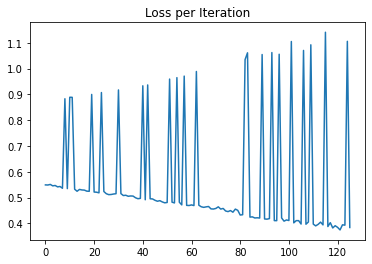

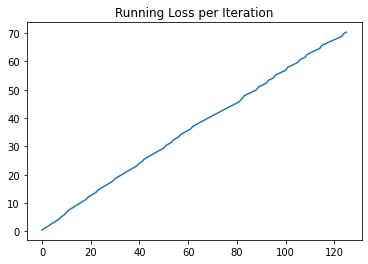

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.title("Loss per Iteration")
plt.show()
plt.plot(running)
plt.title("Running Loss per Iteration")
plt.show()

In [ ]:
#torch.save(net.state_dict(), os.path.join(path, 'model11.pth'))
#state = torch.load(os.path.join(path, 'model5.pth'))
#net.load_state_dict(state)

# Test all models

In [ ]:
ground_truth_pos = 0
ground_truth_negs = 0
comb_true_negs = 0
comb_false_pos = 0
comb_false_negs = 0
comb_samples = 0
comb_corr = 0
svm_true_negs = 0
svm_false_pos = 0
svm_false_negs = 0
svm_samples = 0
svm_corr = 0
pretrained_corr = 0
pretrained_true_negs = 0
pretrained_false_pos = 0
pretrained_false_negs = 0
pretrained_samples = 0
pretrained_corr = 0

test_data = X_val[int(len(X_val)/2):]
svm_classifications = dict()

for cur_data in test_data:
    with torch.no_grad():
        input = [-1, -1]
        vid_name = os.path.splitext(cur_data)[0] 

        # grab label of the data to find the directory where it is stored
        label =  metadata[cur_data]['label']
        if label == 'REAL':
            dir = 'real'
            ground_truth_negs += 1
        else:
            dir = 'fake'
            ground_truth_pos += 1
        # classify with svm
        input[0] = classify(os.path.join(path, 'preprocessed', vid_name), svm)
        
        # classify with svm and test it
        svm_samples += 1
        if dir == 'real':
            if input[0] > 0:
                svm_corr += 1
            else:
                svm_false_pos += 1
        else:
            if input[0] < 0:
                svm_corr += 1
            else:
                svm_false_negs += 1

        # get output from pretrained model
        frames = glob.glob(os.path.join(path, 'dataset', dir, vid_name+'_*'))
        input_frames = list()
        for frame in frames: 
            input_frames.append(img_to_array(load_img(frame)).flatten() / 255.0)
        if not frames:
            continue
            
        pretrained_out = model(np.array(input_frames).reshape(-1, 128, 128, 3))
        input[1] = np.argmax(pretrained_out, 1).mean()
        

        # send to combined
        output = net(torch.tensor(input, dtype=torch.float32).to(device))

        # test pretrained
        comb_samples += 1
        pretrained_samples += 1
        if dir == 'real':
            if input[1].round() == 1:
                pretrained_corr += 1
            else:
                pretrained_false_negs += 1
        else:
            if input[1].round() == 0:
                pretrained_corr += 1
            else:
                pretrained_false_pos += 1
        
        # test combined
        if dir == 'real':
            if torch.argmax(output) == 1:
                comb_corr += 1
            else:
                comb_false_negs += 1
        else:
            if torch.argmax(output) == 0:
                comb_corr += 1
            else:
                comb_false_pos += 1

print("SVM RESULTS\n=================")
print(f"Accuracy score: {svm_corr/svm_samples * 100}% on {svm_samples} samples, False Positives: {svm_false_pos}, False Negatives: {svm_false_negs}\n")

print("PRETRAINED RESULTS\n=================")
print(f"Accuracy score: {pretrained_corr/pretrained_samples * 100}% on {pretrained_samples} samples, False Positives: {pretrained_false_pos}, False Negatives: {pretrained_false_negs}\n")

print("COMBINED RESULTS\n=================")
print(f"Accuracy score: {comb_corr/comb_samples * 100}% on {comb_samples} samples, False Positives: {comb_false_pos}, False Negatives: {comb_false_negs}\n")

print("GROUND TRUTH\n=================")
print(f"True positives: {ground_truth_pos}, True negatives {ground_truth_negs}")

SVM RESULTS
Accuracy score: 69.6969696969697% on 132 samples, False Positives: 22, False Negatives: 18

PRETRAINED RESULTS
Accuracy score: 80.95238095238095% on 126 samples, False Positives: 12, False Negatives: 12

COMBINED RESULTS
Accuracy score: 78.57142857142857% on 126 samples, False Positives: 0, False Negatives: 27

GROUND TRUTH
True positives: 104, True negatives 28
